## Import full data set

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
full_data = pd.read_csv('/content/drive/MyDrive/ST4052/project1_Advanced/pls_df.csv')

In [142]:
full_data.shape

(58592, 46)

## Train test split

In [143]:
X = full_data.drop("is_claim",axis=1)

In [144]:
y = full_data['is_claim']

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
full_train = pd.concat([X_train,y_train],axis=1)

In [147]:
full_train.shape

(46873, 46)

In [148]:
full_test = pd.concat([X_test,y_test],axis=1)

In [149]:
full_test.shape

(11719, 46)

## Save train and test data set

In [150]:
full_train.to_csv("full_train.csv", index=False)

In [151]:
full_test.to_csv("full_test.csv", index=False)

## get pls scores of train set and perform DBSCAN cluster Analysis

In [152]:
from sklearn.cross_decomposition import PLSRegression

In [153]:
pls_x = full_train.drop('is_claim',axis=1)
pls_y = full_train['is_claim']

In [154]:
n_components = 2 # Number of PLS components
pls = PLSRegression(n_components=n_components)
pls.fit(pls_x,pls_y)

PLSRegression()

In [155]:
scores_pls = pls.transform(pls_x)

In [156]:
scores_df = pd.DataFrame(scores_pls)

In [157]:
scores_df.head()

,0,1
0,1.005769,-0.491992
1,-0.956749,-2.877914
2,-1.600721,-1.790756
3,0.861569,-0.219539
4,1.717284,1.509838


In [158]:
scores_df.shape

(46873, 2)

In [159]:
#save train pls scores as csv for cluster analysis
scores_df.to_csv("full_train_scores.csv", index=False)

## Import pls Scores of full train set

In [160]:
X = pd.read_csv("/content/drive/MyDrive/ST4052/project1_Advanced/full_train_scores.csv")

In [161]:
X.head()

,0,1
0,1.005769,-0.491992
1,-0.956749,-2.877914
2,-1.600721,-1.790756
3,0.861569,-0.219539
4,1.717284,1.509838


In [162]:
X.shape

(46873, 2)

# Clustering Using DBScan

In [163]:
from sklearn.cluster import DBSCAN


In [164]:
X1 =  X.copy()

In [165]:
# Perform DBSCAN clustering
eps = 0.13 # Maximum distance between samples to be considered in the same neighborhood # 0.17 / 30
min_samples = 20 # Minimum number of samples in a neighborhood
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(X1)


### Optimizing DBSCAN parameter

* Usually its fine to take min_sample = 2*dim (rule of thumb )
* For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996)

## finding Optimal value for epsilon

In [166]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [167]:
# Calculate the average distance between each point in the data set and its 20 nearest neighbors (my selected MinPts value)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

<function matplotlib.pyplot.show(close=None, block=None)>

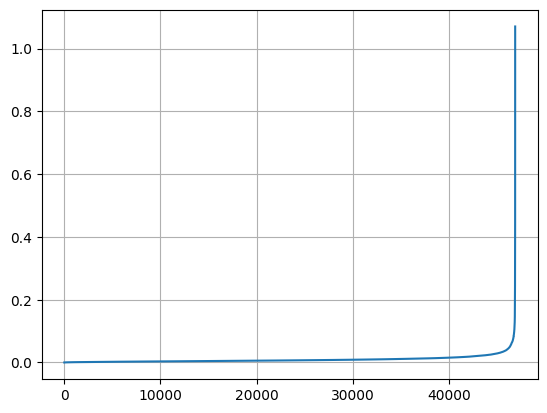

In [168]:
# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)
plt.show


* The ideal value for ε will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature

In [169]:
cluster_labels

array([0, 1, 1, ..., 0, 1, 1])

In [170]:
# Create a DataFrame from the data and add the cluster labels
X1['Cluster'] = cluster_labels



In [171]:
print(X1.head())  # Display the DataFrame with cluster labels

          0         1  Cluster
0  1.005769 -0.491992        0
1 -0.956749 -2.877914        1
2 -1.600721 -1.790756        1
3  0.861569 -0.219539        0
4  1.717284  1.509838        2


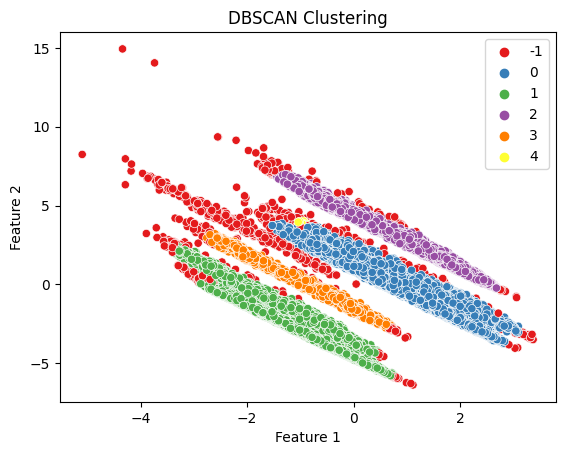

In [172]:
# Plot the observations with colors corresponding to clusters
sns.scatterplot(data=X1, x='0', y='1', hue='Cluster', palette='Set1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

## K-Means Clustering

In [173]:
from sklearn.cluster import KMeans

In [174]:
X2 = X.copy()

In [175]:
n_clusters = 4

In [176]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels_kmeans = kmeans.fit_predict(X2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [177]:
# Create a DataFrame from the data and add the cluster labels
X2['Cluster'] = cluster_labels_kmeans

In [178]:
X2.head()

,0,1,Cluster
0,1.005769,-0.491992,3
1,-0.956749,-2.877914,2
2,-1.600721,-1.790756,2
3,0.861569,-0.219539,3
4,1.717284,1.509838,1


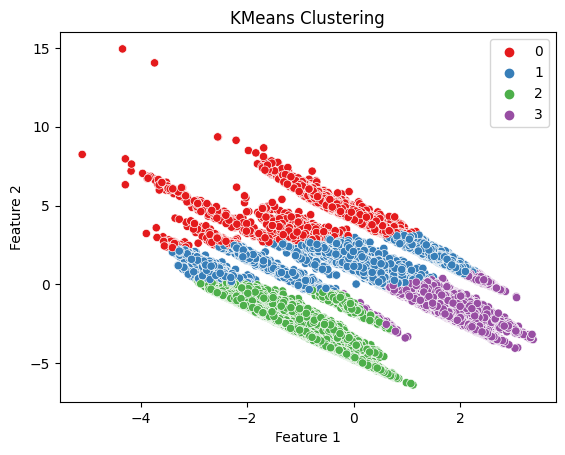

In [179]:
# Plot the observations with colors corresponding to clusters
sns.scatterplot(data=X2, x='0', y='1', hue='Cluster', palette='Set1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

## Sillohoute Analysis -  DBSCAN clusters


In [180]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [181]:
# Compute the silhouette score
silhouette_avg = silhouette_score(X,cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.14134506744733716


In [182]:
print(cluster_labels[:5])

[0 1 1 0 2]


## Combine clusters

In [183]:
# Define the mapping from old labels to new labels
label_mapping = {-1:-1, 0: 0, 1:1, 2: 2, 3:1, 4:2 }

# Apply the label mapping to combine labels
combined_labels = np.vectorize(label_mapping.get,otypes=[int])(cluster_labels)

In [184]:
print(combined_labels[:100])

[ 0  1  1  0  2  2  1  1  1  1 -1  0  1  2  2  0  2  0  0  0  1  0  2  1
  0  1  0  1  1  0  2  1  0  2  0  2  2  1  2  2  1  2  1  0  0  1  1  0
  0  1  2  0  2  0  0  1  1  1  1  2  2  1  2  0  1  1  2  2  0  2  1  2
  2  2  0  1  1  0  1  0  0  1  1  2  2  2  1  2  2  0  1  0  1  1  2  2
  2  0  1  1]


## plot new clusters


In [185]:

df_labels =pd.DataFrame(combined_labels,columns = ['cluster_lables'])

In [186]:
# Compute the silhouette score
silhouette_avg = silhouette_score(X,combined_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.31206273425113257


# Sillouete Analysis plot

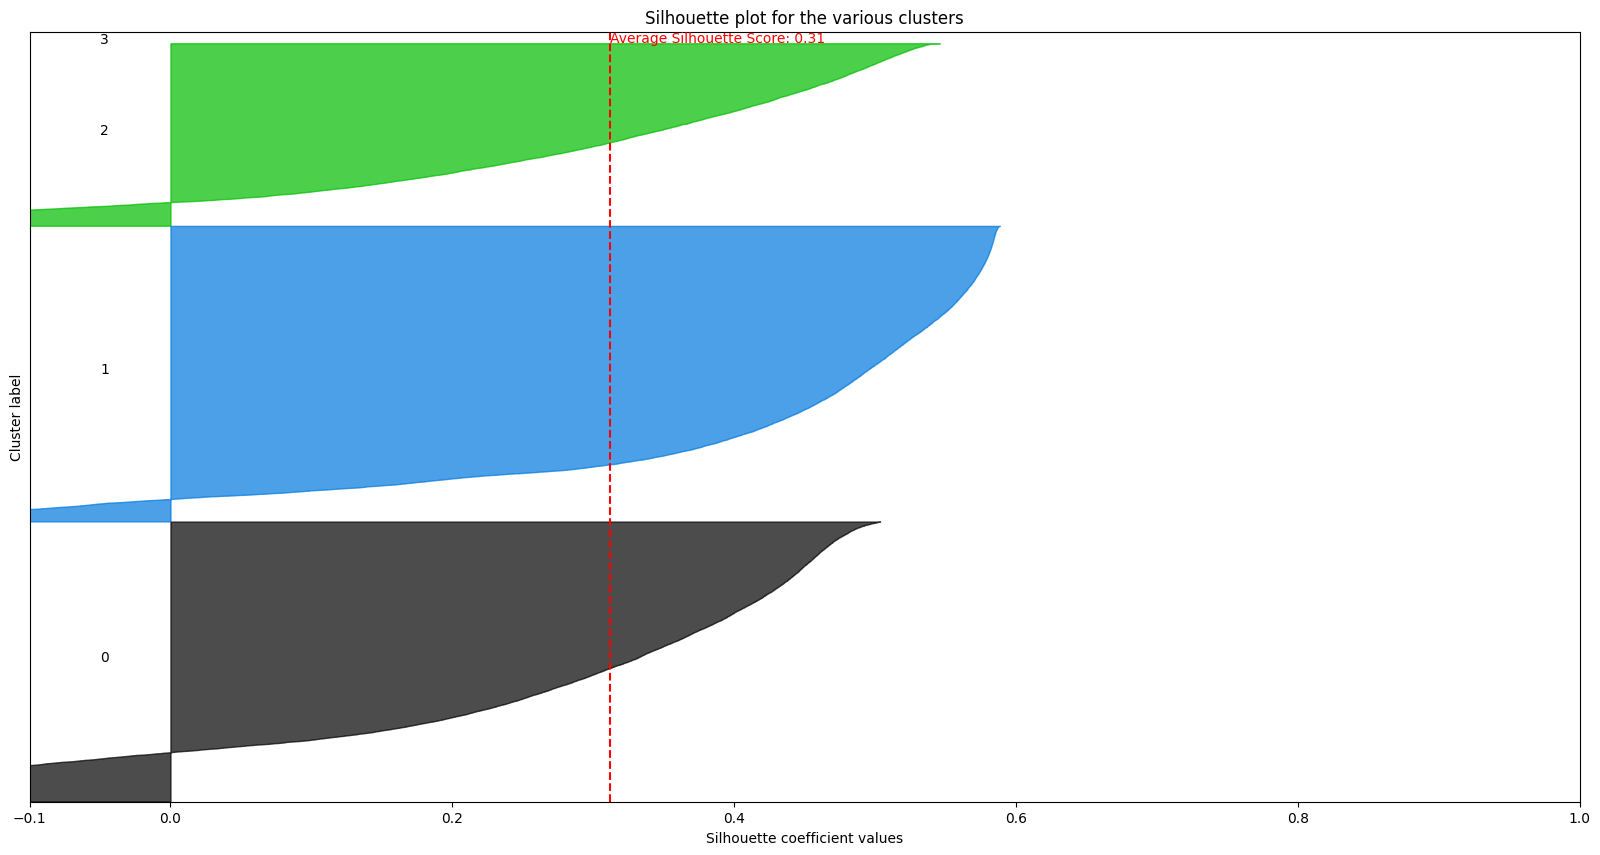

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming you have a DataFrame or array containing your data and cluster labels
# For example, if you are using pandas:
# import pandas as pd
# df = pd.read_csv('your_data.csv')
# labels = df['combined_label'].values

# Compute silhouette scores for each sample
silhouette_avg = silhouette_score(X, combined_labels)
sample_silhouette_values = silhouette_samples(X, combined_labels)

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(20, 10)

# Plot the silhouette values
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + 1])
y_lower = 10

for i in range(4):  # Change this to the number of clusters you have
    ith_cluster_silhouette_values = sample_silhouette_values[combined_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for the next plot
    y_lower = y_upper + 10

ax1.set_title("Silhouette plot for the various clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for the average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.annotate(f'Average Silhouette Score: {silhouette_avg:.2f}', (silhouette_avg, y_lower + 10), color="red")

ax1.set_yticks([])  # Clear the y-axis labels/ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Display the plot
plt.show()


In [188]:
df_labels =pd.DataFrame(combined_labels,columns = ['cluster_lables'])

In [189]:
X1.head()

,0,1,Cluster
0,1.005769,-0.491992,0
1,-0.956749,-2.877914,1
2,-1.600721,-1.790756,1
3,0.861569,-0.219539,0
4,1.717284,1.509838,2


In [190]:
X1 = pd.concat([X1,df_labels],axis=1)

In [191]:
X1.head()

,0,1,Cluster,cluster_lables
0,1.005769,-0.491992,0,0
1,-0.956749,-2.877914,1,1
2,-1.600721,-1.790756,1,1
3,0.861569,-0.219539,0,0
4,1.717284,1.509838,2,2


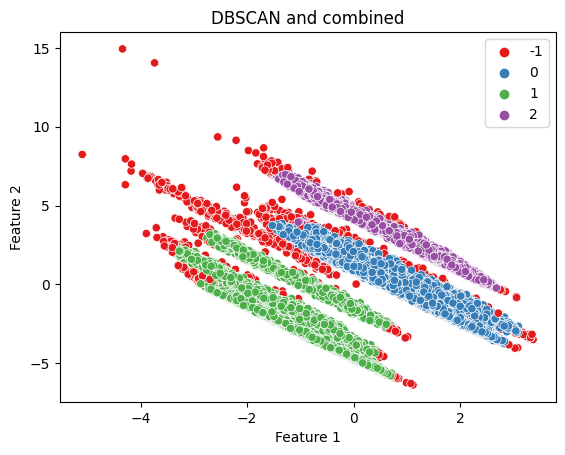

In [192]:
# Plot the observations with colors corresponding to clusters
sns.scatterplot(data=X1, x='0', y='1', hue='cluster_lables', palette='Set1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN and combined')
plt.legend()
plt.show()

### combine cluster labels and original train data set

In [193]:
full_train = pd.read_csv("/content/drive/MyDrive/ST4052/project1_Advanced/full_train.csv")

In [194]:
full_train.head()

,population_density,width,length,height,gross_weight,make,segment_B1,segment_B2,segment_C1,segment_C2,...,policy_tenure,age_of_car,age_of_policyholder,airbags,cylinder,cylinder.1,turning_radius,ncap_rating,no_of_safety_measures,is_claim
0,0.471712,0.773810,0.467836,0.157143,0.424514,1,0,1,0,0,...,1.010772,0.11,0.375000,2,4,4,4.8,2,7,0
1,0.051764,0.119048,0.000000,0.000000,0.200299,1,0,0,0,0,...,0.473653,0.05,0.548077,2,3,3,4.6,0,3,0
2,0.375335,0.119048,0.000000,0.000000,0.200299,1,0,0,0,0,...,0.287461,0.06,0.586538,2,3,3,4.6,0,3,0
3,0.365231,0.773810,0.467836,0.157143,0.424514,1,0,1,0,0,...,0.547799,0.08,0.721154,2,4,4,4.8,2,7,0
4,0.239459,0.937500,1.000000,0.457143,1.000000,3,0,0,0,1,...,1.140288,0.08,0.471154,6,4,4,5.2,3,11,0


In [195]:
full_train.shape

(46873, 46)

In [196]:
full_train_clustered = pd.concat([full_train,df_labels],axis=1)

In [197]:
full_train_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46873 entries, 0 to 46872
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   population_density                     46873 non-null  float64
 1   width                                  46873 non-null  float64
 2   length                                 46873 non-null  float64
 3   height                                 46873 non-null  float64
 4   gross_weight                           46873 non-null  float64
 5   make                                   46873 non-null  int64  
 6   segment_B1                             46873 non-null  int64  
 7   segment_B2                             46873 non-null  int64  
 8   segment_C1                             46873 non-null  int64  
 9   segment_C2                             46873 non-null  int64  
 10  segment_Utility                        46873 non-null  int64  
 11  mo

## Seperate Dataframes according to clusters

In [198]:
df = full_train_clustered.copy()

In [199]:
df_c0 = df[df['cluster_lables'] == 0].copy()
df_c1 = df[df['cluster_lables'] == 1].copy()
df_c3 = df[df['cluster_lables'] == 3].copy()
df_c4 = df[df['cluster_lables'] == 4].copy()

In [200]:
# Create a dictionary to store the separate dataframes
cluster_dataframes = {}
# Iterate through unique cluster labels
for cluster_label in df['cluster_lables'].unique():
    # Filter the dataframe for the current cluster
    cluster_df = df[df['cluster_lables'] == cluster_label]
    # Drop the 'cluster_label' column from the cluster dataframe
    cluster_df = cluster_df.drop(columns=['cluster_lables'])
    # Store the cluster dataframe in the dictionary
    cluster_dataframes[cluster_label] = cluster_df




## Fit randomforest(vanilla) and Logistic(vanilla) for every cluster df and evaluate models

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

results = {}

# Iterate through each cluster and perform train-test split, model training, and evaluation
for cluster_label, cluster_df in cluster_dataframes.items():
    # Split the data into features (X) and target (y)
    X = cluster_df.drop(columns=['is_claim'])
    y = cluster_df['is_claim']

    # Split the data into train and test sets (you can adjust test_size and random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit a Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Initialize and fit a Logistic Regression model
    lr_model = LogisticRegression(random_state=42, max_iter = 10000)
    lr_model.fit(X_train, y_train)

    # Make predictions using the models
    rf_predictions = rf_model.predict(X_test)
    lr_predictions = lr_model.predict(X_test)

    # Calculate accuracy and F1 scores
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    rf_f1_score = f1_score(y_test, rf_predictions)
    lr_f1_score = f1_score(y_test, lr_predictions)

    # Store the results in the dictionary
    results[cluster_label] = {
        'RF Accuracy': rf_accuracy,
        'LR Accuracy': lr_accuracy,
        'RF F1 Score': rf_f1_score,
        'LR F1 Score': lr_f1_score,
    }

# Create a results dataframe from the dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results as a table
print(results_df)


    RF Accuracy  LR Accuracy  RF F1 Score  LR F1 Score
 0     0.930185     0.932238     0.000000          0.0
 1     0.936076     0.942746     0.041667          0.0
 2     0.930243     0.935194     0.000000          0.0
-1     0.965753     0.972603     0.000000          0.0


## check response imbalanceness over cluster dataframes

In [202]:
response_percentages = {}
for cluster_label, cluster_df in cluster_dataframes.items():
    # Calculate the percentage of the binary response variable
    response_percentage = (cluster_df['is_claim'].sum() / len(cluster_df)) * 100
     # Store the percentage in the dictionary
    response_percentages[cluster_label] = response_percentage

results_df = pd.DataFrame.from_dict(response_percentages, orient='index', columns=['Response positive Percentage'])

print(results_df)


    Response positive Percentage
 0                      6.793781
 1                      6.065155
 2                      6.462646
-1                      3.424658


## Balanceing and Evaluate models again

In [203]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score

results = {}

smote = SMOTE(random_state=42)
beta = 2

for cluster_label, cluster_df in cluster_dataframes.items():
    X = cluster_df.drop(columns=['is_claim'])
    y = cluster_df['is_claim']

    X_resampled, y_resampled = smote.fit_resample(X, y)


    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)


    lr_model = LogisticRegression(random_state=42 ,max_iter=10000)
    lr_model.fit(X_train, y_train)


    rf_predictions = rf_model.predict(X_test)
    lr_predictions = lr_model.predict(X_test)


    rf_accuracy = accuracy_score(y_test, rf_predictions)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    rf_f1_score = f1_score(y_test, rf_predictions)
    lr_f1_score = f1_score(y_test, lr_predictions)
    rf_f2_score = fbeta_score(y_test, rf_predictions, beta=beta)
    lr_f2_score = fbeta_score(y_test, lr_predictions, beta=beta)


    results[cluster_label] = {
        'RF Accuracy': rf_accuracy,
        'LR Accuracy': lr_accuracy,
        'RF F1 Score': rf_f1_score,
        'LR F1 Score': lr_f1_score,
        'RF F2 Score': rf_f2_score,
        'LR F2 Score': lr_f2_score,
    }

# Create a results dataframe from the dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results as a table
print(results_df)


    RF Accuracy  LR Accuracy  RF F1 Score  LR F1 Score  RF F2 Score  \
 0     0.936271     0.588828     0.934540     0.605585     0.926009   
 1     0.936529     0.564729     0.936772     0.564148     0.933059   
 2     0.943469     0.594178     0.941846     0.613162     0.931747   
-1     0.953901     0.769504     0.954064     0.778157     0.960171   

    LR F2 Score  
 0     0.625000  
 1     0.560165  
 2     0.634732  
-1     0.799439  


## Choose best model for each cluster and make ensemble model and get prediction for original test set

In [204]:
#Import original test data set
full_test = pd.read_csv("/content/drive/MyDrive/ST4052/project1_Advanced/full_test.csv")


In [205]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

rf_models = []

smote = SMOTE(random_state=42)

beta = 2.0

# Create lists to store predictions and evaluation results for soft and hard voting
soft_voting_predictions = []
hard_voting_predictions = []
evaluation_results = []

# Iterate through each cluster and fit a Random Forest model
for cluster_label, cluster_df in cluster_dataframes.items():
    # Split the data into features (X) and target (y)
    X = cluster_df.drop(columns=['is_claim'])
    y = cluster_df['is_claim']

    # Apply SMOTE to balance the dataset
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Split the resampled data into train and test sets (you can adjust test_size and random_state)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Initialize and fit a Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Store the fitted model in the list
    rf_models.append(('cluster_' + str(cluster_label), rf_model))

# Create the ensemble model using a VotingClassifier for soft voting
soft_voting_ensemble = VotingClassifier(estimators=rf_models, voting='soft')

# Fit the ensemble model on the combined data
X_combined = pd.concat([cluster_df.drop(columns=['is_claim']) for cluster_df in cluster_dataframes.values()])
y_combined = pd.concat([cluster_df['is_claim'] for cluster_df in cluster_dataframes.values()])
soft_voting_ensemble.fit(X_combined, y_combined)

# Make predictions for the 'full_test' dataset using the ensemble model for soft voting
X_full_test = full_test.drop(columns=['is_claim'])
soft_voting_predictions = soft_voting_ensemble.predict(X_full_test)

# Calculate evaluation metrics for soft voting
y_true = full_test['is_claim']
soft_voting_accuracy = accuracy_score(y_true, soft_voting_predictions)
soft_voting_precision = precision_score(y_true, soft_voting_predictions)
soft_voting_recall = recall_score(y_true, soft_voting_predictions)
soft_voting_f1 = f1_score(y_true, soft_voting_predictions)
soft_voting_f2 = fbeta_score(y_true, soft_voting_predictions, beta=beta)

# Append the evaluation results for soft voting
evaluation_results.append({
    'Voting Type': 'Soft Voting',
    'Accuracy': soft_voting_accuracy,
    'Precision': soft_voting_precision,
    'Recall': soft_voting_recall,
    'F1 Score': soft_voting_f1,
    'F2 Score': soft_voting_f2
})

# Create the ensemble model using a VotingClassifier for hard voting
hard_voting_ensemble = VotingClassifier(estimators=rf_models, voting='hard')

# Fit the ensemble model on the combined data
hard_voting_ensemble.fit(X_combined, y_combined)

# Make predictions for the 'full_test' dataset using the ensemble model for hard voting
hard_voting_predictions = hard_voting_ensemble.predict(X_full_test)

# Calculate evaluation metrics for hard voting
hard_voting_accuracy = accuracy_score(y_true, hard_voting_predictions)
hard_voting_precision = precision_score(y_true, hard_voting_predictions)
hard_voting_recall = recall_score(y_true, hard_voting_predictions)
hard_voting_f1 = f1_score(y_true, hard_voting_predictions)
hard_voting_f2 = fbeta_score(y_true, hard_voting_predictions, beta=beta)

# Append the evaluation results for hard voting
evaluation_results.append({
    'Voting Type': 'Hard Voting',
    'Accuracy': hard_voting_accuracy,
    'Precision': hard_voting_precision,
    'Recall': hard_voting_recall,
    'F1 Score': hard_voting_f1,
    'F2 Score': hard_voting_f2
})

# Create a results dataframe from the evaluation results
results_df = pd.DataFrame(evaluation_results)

# Display the evaluation results
print(results_df)


   Voting Type  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Soft Voting  0.931393   0.086207  0.006614  0.012285  0.008112
1  Hard Voting  0.931393   0.086207  0.006614  0.012285  0.008112
